# Natural Language Pre-Processing

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re

## Learning Goals

SWBAT:
- describe the basic concepts of NLP
- use pre-processing methods for NLP 
    - tokenization
    - stopword removal

## 1. Overview of NLP

NLP allows computers to interact with text data in a structured and sensible way. In short, we will be breaking up series of texts into individual words (or groups of words), and isolating the words with **semantic value**.  We will then compare texts with similar distributions of these words, and group them together.

In this section, we will discuss some steps and approaches to common text data analytic procedures. Some of the applications of natural language processing are:
- Chatbots 
- Speech recognition and audio processing 
- Classifying documents 

Here is an example that uses some of the tools we use in this notebook.  
  -[chi_justice_project](https://chicagojustice.org/research/justice-media-project/)  
  -[chicago_justice classifier](https://github.com/chicago-justice-project/article-tagging/blob/master/lib/notebooks/bag-of-words-count-stemmed-binary.ipynb)

We will introduce you to the preprocessing steps, feature engineering, and other steps you need to take in order to format text data for machine learning tasks. 

We will also introduce you to [**NLTK**](https://www.nltk.org/) (Natural Language Toolkit), which will be our main tool for engaging with textual data.

## NLP process

<img src="img/nlp_process.png" style="width:1000px;">

## 2. Preprocessing for NLP

In [ ]:
# !pip install nltk
# !conda install -c anaconda nltk

We will be working with a dataset which includes both **satirical** (The Onion) and real news (Reuters) articles. 

We refer to the entire set of articles as the **corpus**.  

![the_onion](img/the_onion.jpeg) ![reuters](img/reuters.png)

In [5]:
corpus = pd.read_csv('data/satire_nosatire.csv')
corpus.shape

(1000, 2)

In [6]:
corpus.head()

,body,target
0,Noting that the resignation of James Mattis as...,1
1,Desperate to unwind after months of nonstop wo...,1
2,"Nearly halfway through his presidential term, ...",1
3,Attempting to make amends for gross abuses of ...,1
4,Decrying the Senate’s resolution blaming the c...,1


Our goal is to detect satire, so our target class of 1 is associated with The Onion articles.  

In [7]:
corpus.loc[10].body

'In recognition of the brave and altruistic Americans who risk their health and safety for the greater good, Pentagon officials announced Thursday that the U.S. military would honor the sacrifices of NFL players by wearing their jerseys throughout December. “Every week, these men are out there on the gridiron, putting their bodies on the line for our country. Having our soldiers wear these jerseys and caps is the least we can do to show our support,” said Pentagon spokesperson Robert D’Amato, who announced that all active-duty soldiers would be sporting gear from all 32 teams to raise awareness of the people who put their lives aside to preserve the American way of life. “These men leave their homes and their families and travel to cities across the country to uphold our nation’s traditions. They are battered and bruised for years, their lives often cut short while we sit back in our barracks and enjoy our freedom. Some of them are never the same after they end their service, and yet w

In [8]:
corpus.loc[10].target

1

In [9]:
corpus.loc[502].body

' Indonesia will launch a renewed search effort as early as Tuesday to find the cockpit voice recorder from a Lion Air jet that crashed into the Java Sea in October, the head of its accident investigation agency said. “If the weather is good, the ship will start to depart today,” National Transporation Safety Commission (KNKT) Chief Soerjanto Tjahjono told Reuters on Tuesday. The crash, the world’s first of a Boeing Co (BA.N) 737 MAX jet and the deadliest of 2018, killed all 189 people on board. Investigators last week said they planned to use a navy ship for a fresh search for the crashed jet’s second “black box” after a 10-day effort funded by Lion Air failed to find the cockpit voice recorder (CVR). A KNKT source, speaking on condition of anonymity, told Reuters the team will have seven days using the ship KRI Spica to find the CVR, which could hold vital clues giving investigators insight into the actions of the doomed jet’s pilots. Tjahjono declined to comment on whether there was

In [10]:
corpus.loc[502].target

0

Each article in the corpus is refered to as a **document**.

It is a balanced dataset with 500 documents of each category. 

In [11]:
corpus.target.value_counts()

0    500
1    500
Name: target, dtype: int64

Let's think about our types of error and the use cases of being able to correctly separate satirical from authentic news. What type of error should we decide to optimize our models for?  

In [ ]:
# Thoughts here

# is it more important that we mark all satirical pieces, or
# is it more important that we fail to mark all genuine pieces?

# Lean toward this:
# If working for social media, maybe rather not miss real news
# Interested in minimizing false positives

# If worried about stopping damaging, possibly radicalizing disinformation, maybe rather go on safe side
# Interested in minimizing false negative

### Tokenization 

In order to convert the texts into data suitable for machine learning, we need to break down the documents into smaller parts. 

The first step in doing that is **tokenization**.

Tokenization is the process of splitting documents into units of observations. We usually represent the tokens as __n-grams__, where n represent the number of consecutive words occuring in a document that we will consider a unit. In the case of unigrams (one-word tokens), the sentence "David works here" would be tokenized into:

- "David", "works", "here";

If we want (also) to consider bigrams, we would (also) consider:

- "David works" and "works here".

Let's consider the first document in our corpus:

In [14]:
first_document = corpus.iloc[0].body

In [15]:
first_document

'Noting that the resignation of James Mattis as Secretary of Defense marked the ouster of the third top administration official in less than three weeks, a worried populace told reporters Friday that it was unsure how many former Trump staffers it could safely reabsorb. “Jesus, we can’t just take back these assholes all at once—we need time to process one before we get the next,” said 53-year-old Gregory Birch of Naperville, IL echoing the concerns of 323 million Americans in also noting that the country was only now truly beginning to reintegrate former national security advisor Michael Flynn. “This is just not sustainable. I’d say we can handle maybe one or two more former members of Trump’s inner circle over the remainder of the year, but that’s it. This country has its limits.” The U.S. populace confirmed that they could not handle all of these pieces of shit trying to rejoin society at once.'

There are many ways to tokenize our document. 

It is a long string, so the first way we might consider is to split it by spaces.

In [13]:
# code

first_document.split()

['Noting',
 'that',
 'the',
 'resignation',
 'of',
 'James',
 'Mattis',
 'as',
 'Secretary',
 'of',
 'Defense',
 'marked',
 'the',
 'ouster',
 'of',
 'the',
 'third',
 'top',
 'administration',
 'official',
 'in',
 'less',
 'than',
 'three',
 'weeks,',
 'a',
 'worried',
 'populace',
 'told',
 'reporters',
 'Friday',
 'that',
 'it',
 'was',
 'unsure',
 'how',
 'many',
 'former',
 'Trump',
 'staffers',
 'it',
 'could',
 'safely',
 'reabsorb.',
 '“Jesus,',
 'we',
 'can’t',
 'just',
 'take',
 'back',
 'these',
 'assholes',
 'all',
 'at',
 'once—we',
 'need',
 'time',
 'to',
 'process',
 'one',
 'before',
 'we',
 'get',
 'the',
 'next,”',
 'said',
 '53-year-old',
 'Gregory',
 'Birch',
 'of',
 'Naperville,',
 'IL',
 'echoing',
 'the',
 'concerns',
 'of',
 '323',
 'million',
 'Americans',
 'in',
 'also',
 'noting',
 'that',
 'the',
 'country',
 'was',
 'only',
 'now',
 'truly',
 'beginning',
 'to',
 'reintegrate',
 'former',
 'national',
 'security',
 'advisor',
 'Michael',
 'Flynn.',
 '“This

But this is not ideal. We are trying to create a set of tokens with **high semantic value**.  In other words, we want to isolate text which best represents the meaning in each document.

### Common text cleaning tasks:  
  1. remove capitalization  
  2. remove punctuation  
  3. remove stopwords  
  4. remove numbers

We could manually perform all of these tasks with string operations.

#### Capitalization

When we create our matrix of words associated with our corpus, **capital letters** will mess things up.  The semantic value of a word used at the beginning of a sentence is the same as that same word in the middle of the sentence.  In the two sentences:

sentence_one =  "Excessive gerrymandering in small counties suppresses turnout."   
sentence_two =  "Turnout is suppressed in small counties by excessive gerrymandering."  

'excessive' has the same semantic value, but will be treated as different tokens because of capitals.

In [16]:
sentence_one =  "Excessive gerrymandering in small counties suppresses turnout." 
sentence_two =  "Turnout is suppressed in small counties by excessive gerrymandering."

Excessive = sentence_one.split(' ')[0]
excessive = sentence_two.split(' ')[-2]
print(excessive, Excessive)
excessive == Excessive

excessive Excessive


False

In [17]:
manual_cleanup = [word.lower() for word in first_document.split(' ')]

In [18]:
print(f"Our initial token set for our first document is {len(manual_cleanup)} words long")

Our initial token set for our first document is 154 words long


In [19]:
print(f"Our initial token set for our first document has \
{len(set(first_document.split()))} unique words")

Our initial token set for our first document has 117 unique words


In [20]:
print(f"After removing capitals, our first document has \
{len(set(manual_cleanup))} unique words")

After removing capitals, our first document has 115 unique words


#### Punctuation

Like capitals, splitting on white space will create tokens which include punctuation that will muck up our semantics.  

Returning to the above example, 'gerrymandering' and 'gerrymandering.' will be treated as different tokens.

In [21]:
no_punct = sentence_one.split(' ')[1]
punct = sentence_two.split(' ')[-1]
print(no_punct, punct)
no_punct == punct

gerrymandering gerrymandering.


False

In [22]:
## Manual removal of punctuation

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
manual_cleanup = [s.translate(str.maketrans('', '', string.punctuation))\
                  for s in manual_cleanup]

In [24]:
print(f"After removing punctuation, our first document has \
{len(set(manual_cleanup))} unique words")

After removing punctuation, our first document has 114 unique words


#### Stopwords

Stopwords are the **filler** words in a language: prepositions, articles, conjunctions. They have low semantic value, and almost always need to be removed.  

Luckily, NLTK has lists of stopwords ready for our use.

In [25]:
stopwords.__dict__

{'_LazyCorpusLoader__name': 'stopwords',
 '__name__': 'stopwords',
 '_LazyCorpusLoader__reader_cls': nltk.corpus.reader.wordlist.WordListCorpusReader,
 'subdir': 'corpora',
 '_LazyCorpusLoader__args': ('(?!README|\\.).*',),
 '_LazyCorpusLoader__kwargs': {'encoding': 'utf8'}}

In [30]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [33]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
stopwords.words('greek')[:10]

['αλλα',
 'αν',
 'αντι',
 'απο',
 'αυτα',
 'αυτεσ',
 'αυτη',
 'αυτο',
 'αυτοι',
 'αυτοσ']

Let's see which stopwords are present in our first document.

In [32]:
stops = [token for token in manual_cleanup if token in stopwords.words('english')]
stops[:10]

['that', 'the', 'of', 'as', 'of', 'the', 'of', 'the', 'in', 'than']

In [34]:
print(f'There are {len(stops)} stopwords in the first document')

There are 63 stopwords in the first document


In [35]:
print(f'That is {len(stops)/len(manual_cleanup): 0.2%} of our text')

That is  40.91% of our text


Let's also use the **FreqDist** tool to look at the makeup of our text before and after removal:

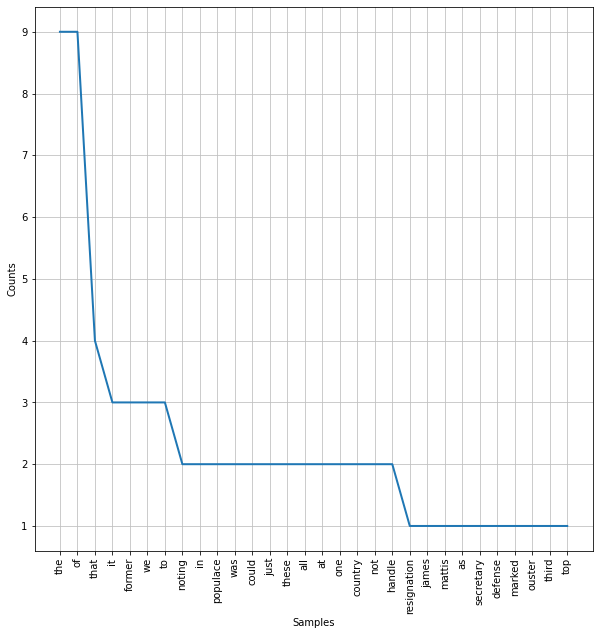

In [36]:
fdist = FreqDist(manual_cleanup)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [37]:
manual_cleanup = [token for token in manual_cleanup if\
                  token not in stopwords.words('english')]

In [38]:
# We can also customize our stopwords list

custom_sw = stopwords.words('english')
custom_sw.extend(["i'd","say"] )
custom_sw[-10:]

['wasn',
 "wasn't",
 'weren',
 "weren't",
 'won',
 "won't",
 'wouldn',
 "wouldn't",
 "i'd",
 'say']

In [39]:
manual_cleanup = [token for token in manual_cleanup if token not in custom_sw]

In [40]:
print(f'After removing stopwords, there are {len(set(manual_cleanup))} unique words left')

After removing stopwords, there are 82 unique words left


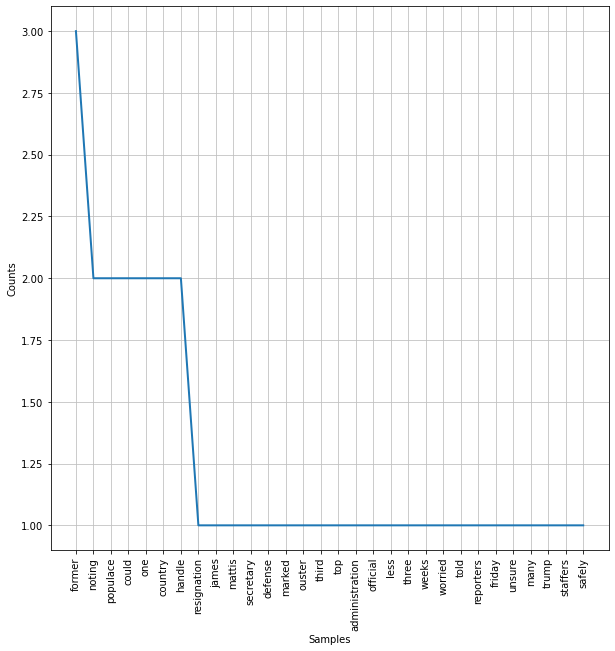

In [41]:
fdist = FreqDist(manual_cleanup)
plt.figure(figsize=(10, 10))
fdist.plot(30);

#### Numbers

Numbers also usually have low semantic value. Their removal can help improve our models. 

To remove them, we will use regular expressions, a powerful tool which you may already have some familiarity with.

Regex allows us to match strings based on a pattern.  This pattern comes from a language of identifiers, which we can begin exploring on the cheatsheet found here:
  -   https://regexr.com/

A few key symbols:
  - . : matches any character
  - \d, \w, \s : represent digit, word, whitespace  
  - *, ?, +: matches 0 or more, 0 or 1, 1 or more of the preceding character  
  - [A-Z]: matches any capital letter  
  - [a-z]: matches lowercase letter  

Other helpful resources:
  - https://regexcrossword.com/
  - https://www.regular-expressions.info/tutorial.html

We can use regex to isolate numbers:

In [42]:
first_document

'Noting that the resignation of James Mattis as Secretary of Defense marked the ouster of the third top administration official in less than three weeks, a worried populace told reporters Friday that it was unsure how many former Trump staffers it could safely reabsorb. “Jesus, we can’t just take back these assholes all at once—we need time to process one before we get the next,” said 53-year-old Gregory Birch of Naperville, IL echoing the concerns of 323 million Americans in also noting that the country was only now truly beginning to reintegrate former national security advisor Michael Flynn. “This is just not sustainable. I’d say we can handle maybe one or two more former members of Trump’s inner circle over the remainder of the year, but that’s it. This country has its limits.” The U.S. populace confirmed that they could not handle all of these pieces of shit trying to rejoin society at once.'

In [43]:
pattern = '[0-9]'
number = re.findall(pattern, first_document)
number

['5', '3', '3', '2', '3']

In [46]:
pattern2 = '[0-9]+'
number2 = re.findall(pattern2, first_document)
number2

['53', '323']

Sklearn and NLTK provide us with a suite of **tokenizers** for our text preprocessing convenience.

In [47]:
first_document

'Noting that the resignation of James Mattis as Secretary of Defense marked the ouster of the third top administration official in less than three weeks, a worried populace told reporters Friday that it was unsure how many former Trump staffers it could safely reabsorb. “Jesus, we can’t just take back these assholes all at once—we need time to process one before we get the next,” said 53-year-old Gregory Birch of Naperville, IL echoing the concerns of 323 million Americans in also noting that the country was only now truly beginning to reintegrate former national security advisor Michael Flynn. “This is just not sustainable. I’d say we can handle maybe one or two more former members of Trump’s inner circle over the remainder of the year, but that’s it. This country has its limits.” The U.S. populace confirmed that they could not handle all of these pieces of shit trying to rejoin society at once.'

In [52]:
# Remember that the '?' indicates 0 or 1 of what follows!

re.findall(r"([a-zA-Z]+(?:'[a-z]+)?)", "I'd")

["I'd"]

In [49]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
first_doc = tokenizer.tokenize(first_document)
first_doc = [token.lower() for token in first_doc]
first_doc = [token for token in first_doc if token not in custom_sw]
first_doc[10]

'administration'

In [50]:
print(f'We are down to {len(set(first_doc))} unique words')

We are down to 79 unique words


In [53]:
first_doc[-1]

'society'

In [54]:
'once' in custom_sw

True

In [64]:
'a' in [token for token in first_doc]

False

In [60]:
's' in custom_sw

True

In [61]:
'e' in first_doc[-1]

True

In [62]:
found = False
for token in first_doc:
    if 'a' in token:
        found = True
        break

In [63]:
found

True

In [66]:
True in ['a' in token for token in first_doc]

True

In [67]:
True in ['.' in token for token in first_doc]

False